# Project 9: Partial Correlations and Directed Acyclic Graphs

## Chains

Text(0.5, 1.0, 'Chain')

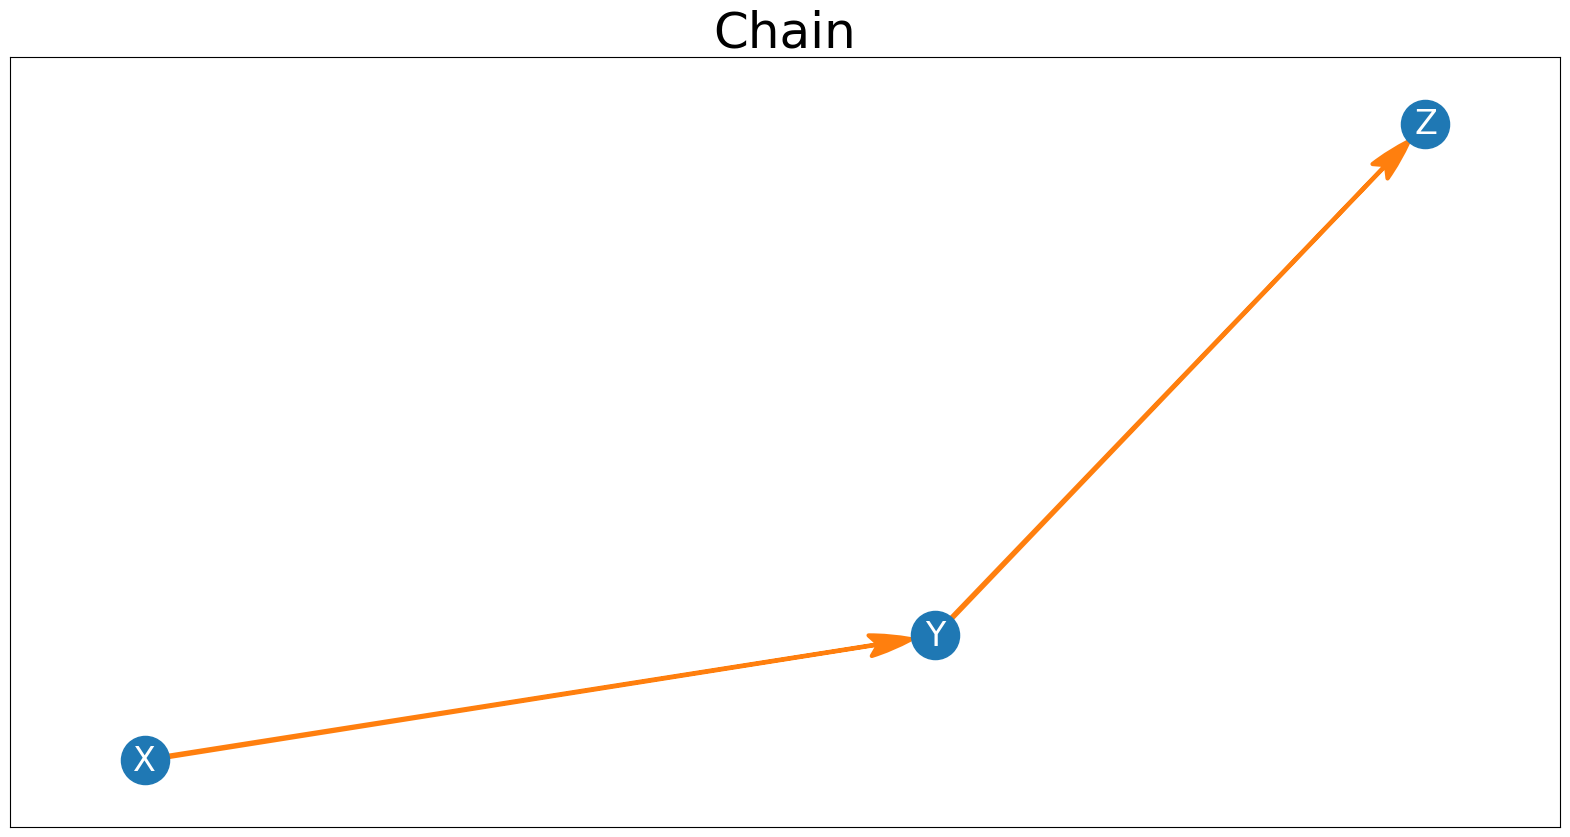

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.patches import ArrowStyle
plt.rcParams.update({"font.size":30})
# initiate graph object
G = nx.DiGraph()
G.add_edges_from([("X","Y"), ("Y", "Z")])
pos = nx.spring_layout(G)
arrow_style = ArrowStyle("Fancy, head_length=3, head_width=1.5, tail_width=.1")

#graph
fig,ax = plt.subplots(figsize = (20,10))
nx.draw_networkx(G, pos, node_size = 1200,
                with_labels = True, arrows = True, 
                font_color = "white",
                font_size = 24, alpha = 1, 
                width = 3, edge_color = "C1",
                arrowstyle = arrow_style, ax = ax)
ax.set_title("Chain")

In [2]:
# import random
import numpy as np
import pandas as pd

length = 100000
cols = ["X", "Y", "Z"]
chain = {col:[] for col in cols}
for i in range(length):
    chain["X"].append(np.random.normal(0,1))
    chain["Y"].append(chain["X"][-1]* -1 + np.random.normal(0,2))
    chain["Z"].append(chain["Y"][-1]* .5 + np.random.normal(0,1))
    
chain = pd.DataFrame(chain)
chain

X         Y         Z
0     -0.281605  2.009395  2.088991
1     -1.006334  2.800126  2.022228
2      0.224105  0.667574 -0.010735
3      1.204311 -4.060051 -1.968846
4      0.670356  2.793427 -0.096105
...         ...       ...       ...
99995 -2.324296  0.648644  1.373931
99996 -0.504243  0.951083  2.077035
99997  0.034014 -2.925482 -1.109710
99998  0.319122 -0.878322 -2.340217
99999  0.713162 -0.892942  0.040486

[100000 rows x 3 columns]

In [3]:
chain.corr()

X         Y         Z
X  1.000000 -0.445838 -0.333142
Y -0.445838  1.000000  0.745781
Z -0.333142  0.745781  1.000000

C:\Users\aleah\Documents\Computational-Economics\in-class projects\datlib\plots.py:120: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  pd.plotting.scatter_matrix(data, c = c, alpha = alpha, s = 200 / num_vars, ax=ax)


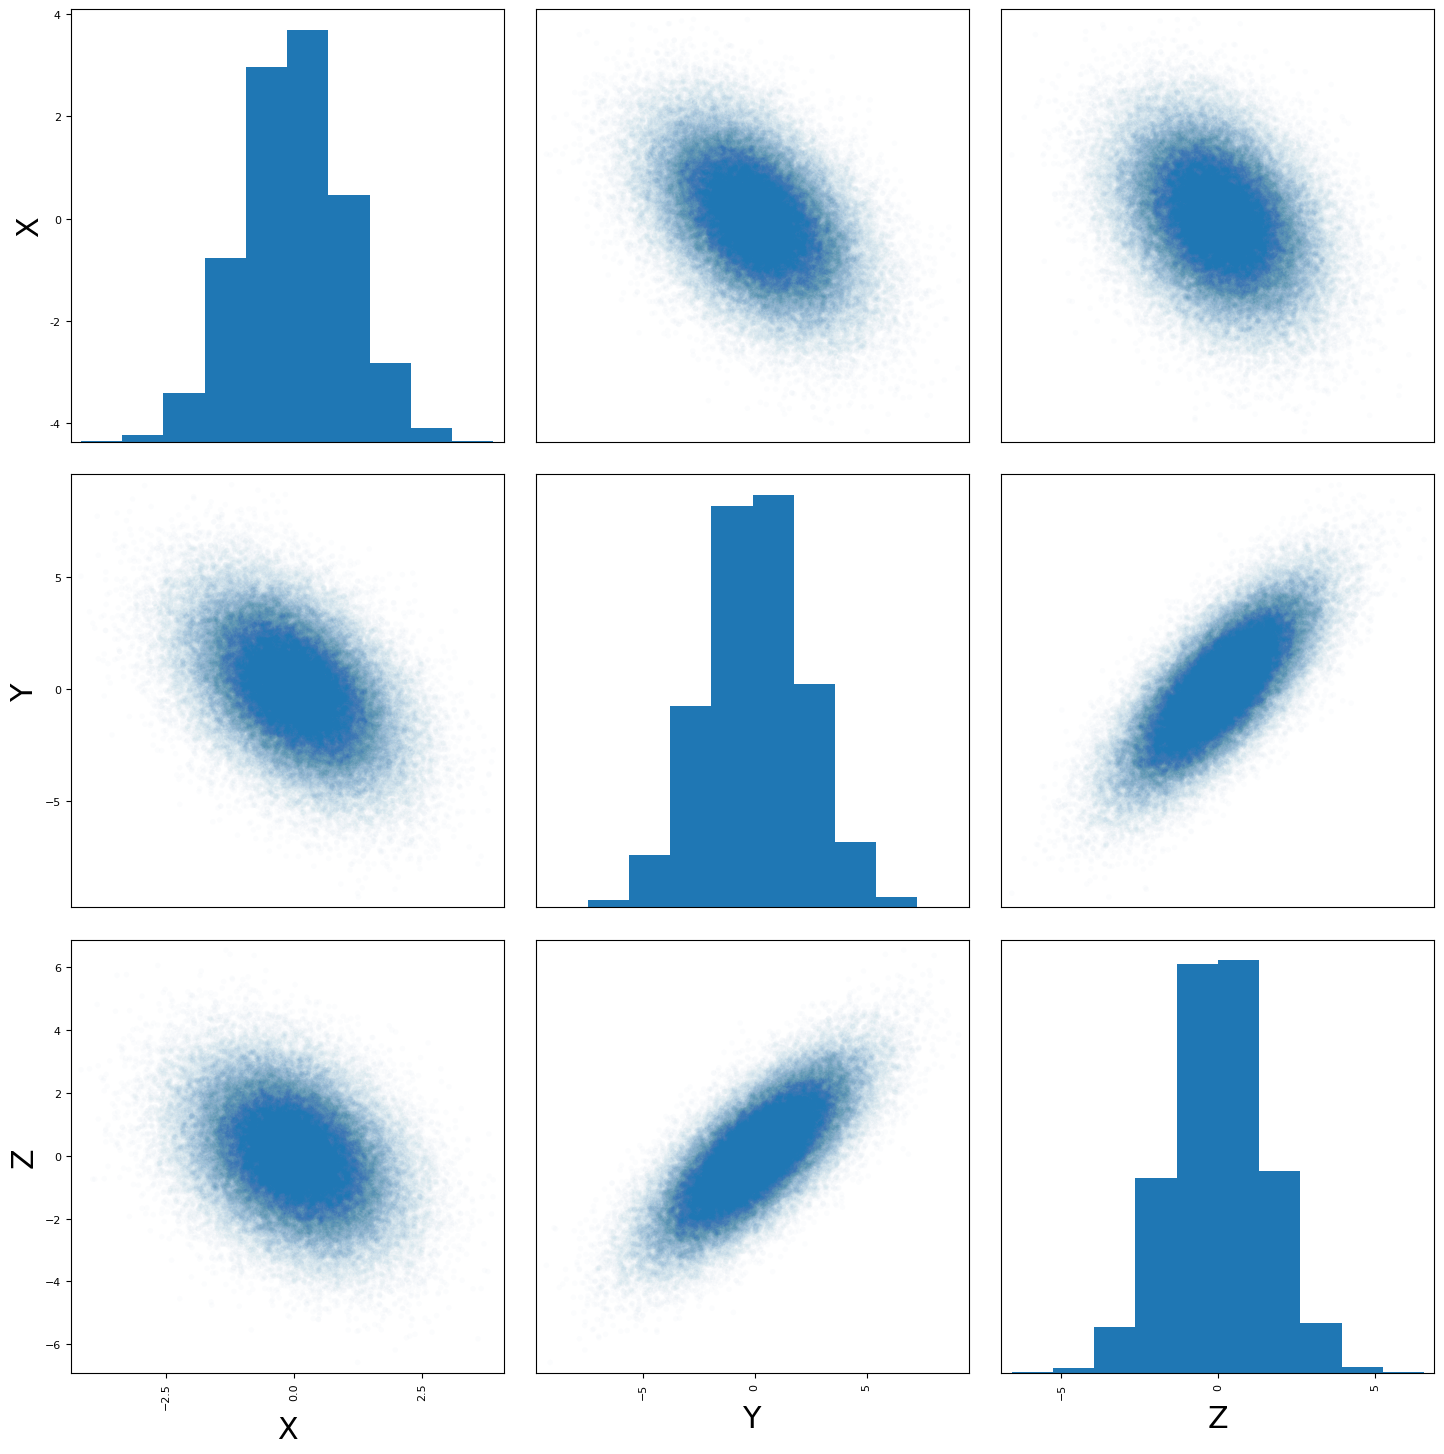

In [4]:
plt.rcParams.update({"font.size":30})
from datlib.plots import *
formatted_scatter_matrix(chain, alpha = 0.015)

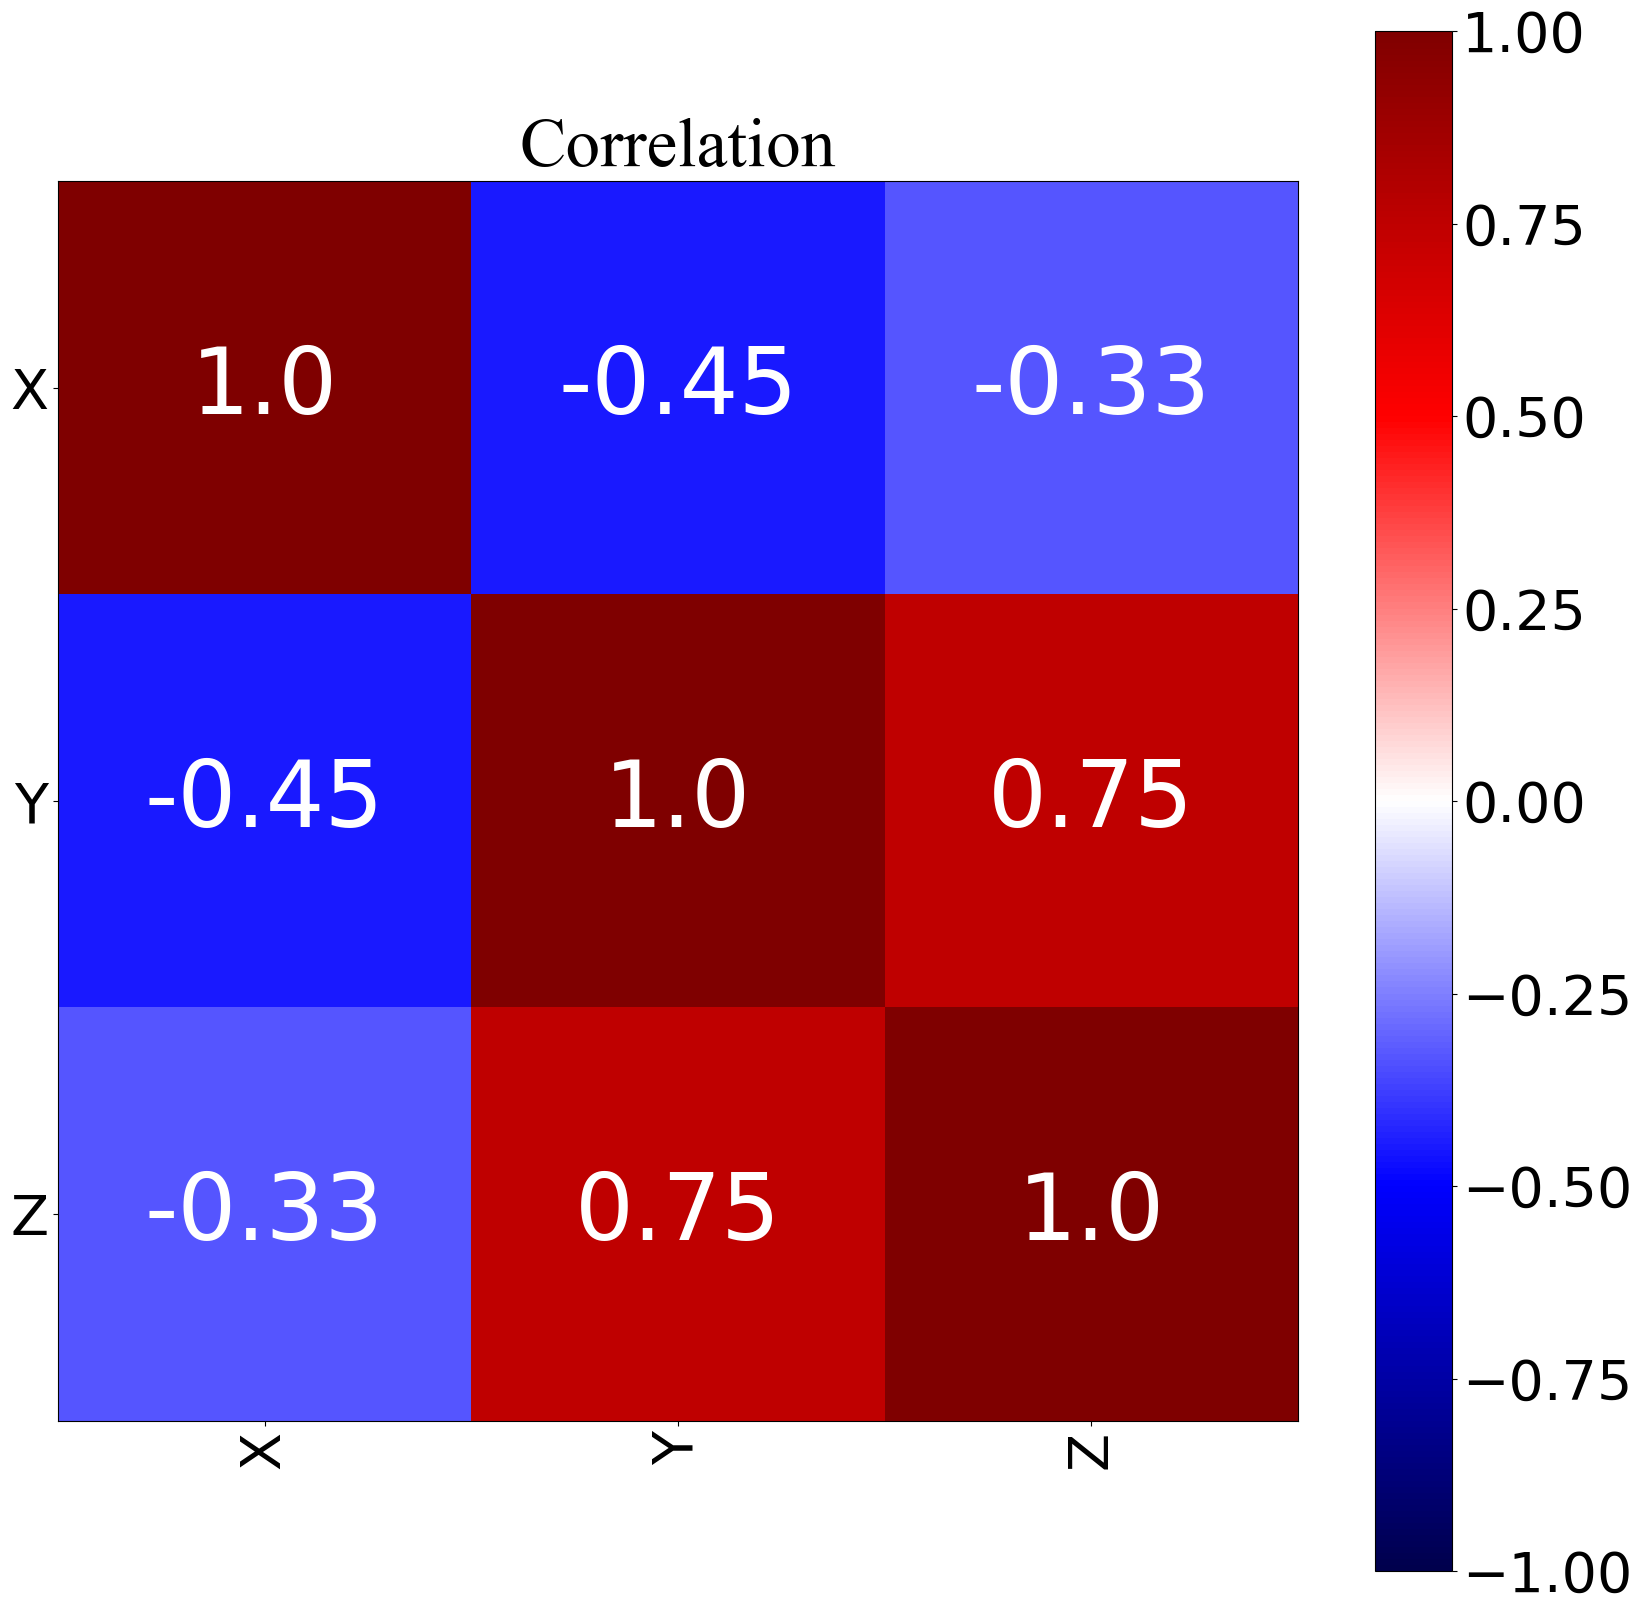

In [5]:
corr_matrix_heatmap(chain.corr(), 
                    save_fig = False, 
                    pp = None, 
                    title = "Correlation")

If we control for $Y$, however, we see that that there is no longer any correlation between $X$ and $Z$. This is called a partial correlation. In the following matrix, partial correlations of each pair are calculated using the remaing variable as a control. We can interpret the result as:

$X \!\perp\!\!\!\perp Z|Y$ 

$if$ $Corr(X,Z|Y)\approx 0.00$

First, let's substantiate this intuition using an OLS regression. We run the regression for:

$X = \beta_0 + \beta_Y + \beta_Z + \epsilon_X$

In [6]:
import statsmodels.api as sm

XYc = chain[["Y", "X"]]
XYc["Constant"] = 1
Z = chain [["Z"]]

model = sm.OLS(Z, XYc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.556
Model:                            OLS   Adj. R-squared:                  0.556
Method:                 Least Squares   F-statistic:                 6.266e+04
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:59:27   Log-Likelihood:            -1.4179e+05
No. Observations:              100000   AIC:                         2.836e+05
Df Residuals:                   99997   BIC:                         2.836e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Y              0.5008      0.002    316.720      0.000       0.498       0.504
X             -0.0012      0.004     -0.342      0.732      -0.008       0.006
Constant       0.0027      0.003      0.850      0.395      -0.004       0.009
==============================================================================
Omnibus:                        1.012   Durbin-Watson:                   2.012
Prob(Omnibus):                  0.603   Jarque-Bera (JB):                1.022
Skew:                          -0.005   Prob(JB):                        0.600
Kurtosis:                       2.989   Cond. No.                         2.62
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [7]:
residuals = {}
def get_residuals(df):
    for y_var in df.keys():
        # save all vars in list of X_vars
        X_vars = list(df.keys())
        # then remove y_var from X_vars
        X_vars.remove(y_var)
        # save X matrix
        X = df[X_vars]
        # add a constant to the X matrix
        X["Constant"] = 1
        y = df[[y_var]]
        model = sm.OLS(y,X)
        results = model.fit()
        # save error
        residuals["$\\epsilon_{" + y_var +"}$"] = results.resid
    return pd.DataFrame(residuals)
residuals = get_residuals(chain)
residuals

$\epsilon_{X}$  $\epsilon_{Y}$  $\epsilon_{Z}$
0            0.125980       -0.216609        1.079760
1           -0.441736        0.280627        0.616161
2            0.363112        0.792834       -0.347438
3            0.402291       -1.489282        0.062995
4            1.231578        3.225894       -1.496789
...               ...             ...             ...
99995       -2.187713       -1.877670        1.043623
99996       -0.306901       -1.373637        1.597484
99997       -0.541795       -1.795664        0.352580
99998        0.148789        1.623817       -1.902698
99999        0.542224       -0.575796        0.485803

[100000 rows x 3 columns]

In [8]:
residuals.corr()

$\epsilon_{X}$  $\epsilon_{Y}$  $\epsilon_{Z}$
$\epsilon_{X}$        1.000000        0.314242        0.001081
$\epsilon_{Y}$        0.314242        1.000000       -0.707662
$\epsilon_{Z}$        0.001081       -0.707662        1.000000

In [9]:
def calculate_partial_corr(residuals):
    pcorr = residuals.corr() * -1
    for x in residuals.keys():
        for y in residuals.keys():
            if x == y:
                pcorr[y][x] = 1
    return pcorr
chain_pcorr = calculate_partial_corr(residuals)
chain_pcorr.rename(columns = {r:r[-3] for r in residuals.keys()},
                  index = {r:r[-3] for r in residuals.keys()},
                  inplace = True)
chain_pcorr

X         Y         Z
X  1.000000 -0.314242 -0.001081
Y -0.314242  1.000000  0.707662
Z -0.001081  0.707662  1.000000

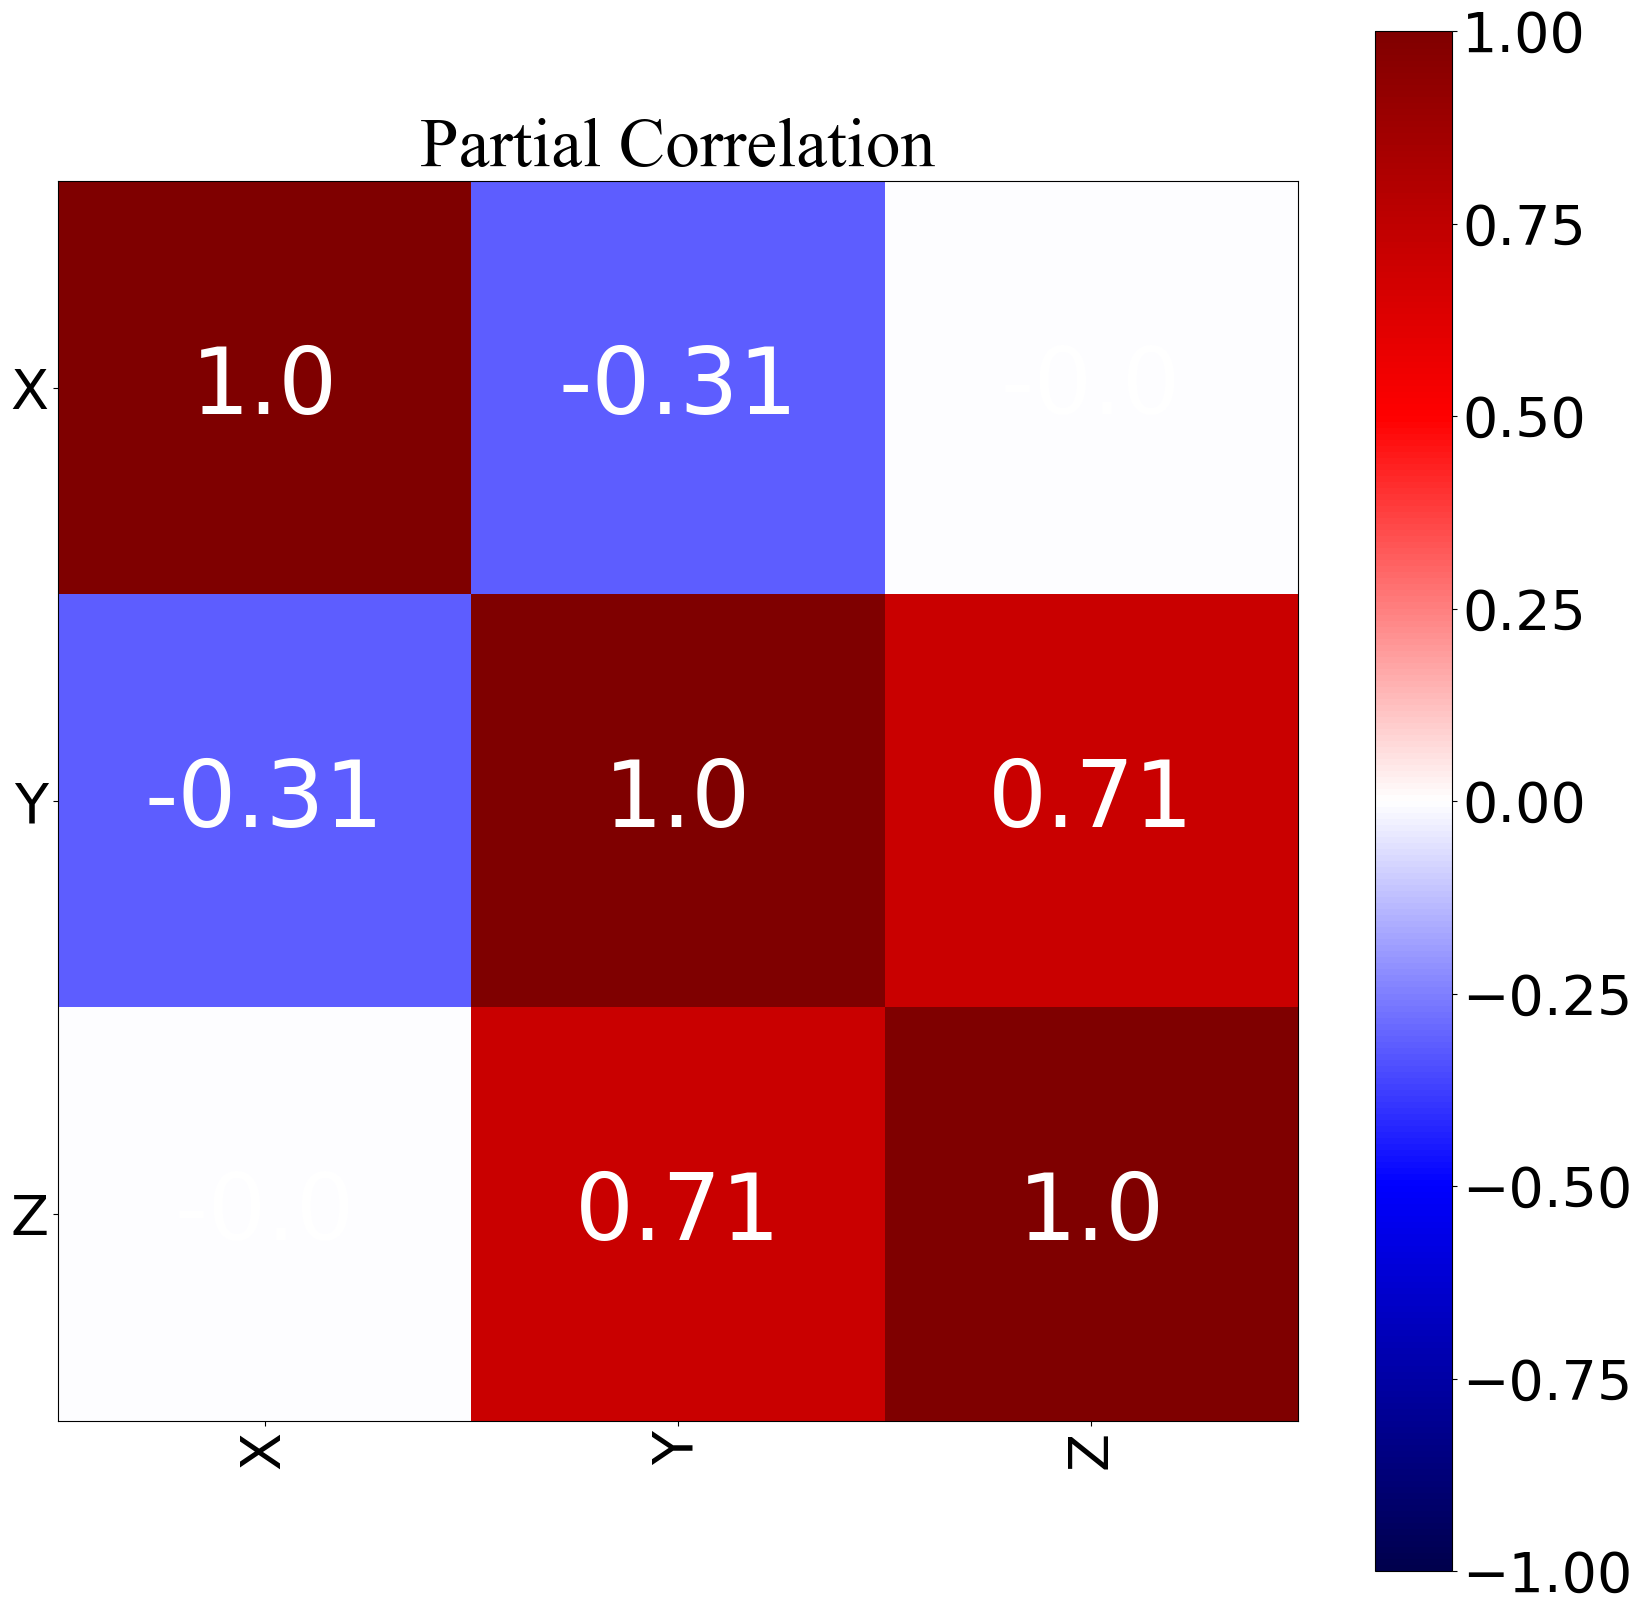

In [10]:
corr_matrix_heatmap(chain_pcorr,
                    save_fig = False,
                    pp = None,
                    title = "Partial Correlation")

In [11]:
# !pip install pingouin
import pingouin
chain.pcorr().round(3)

X      Y      Z
X  1.000 -0.314 -0.001
Y -0.314  1.000  0.708
Z -0.001  0.708  1.000

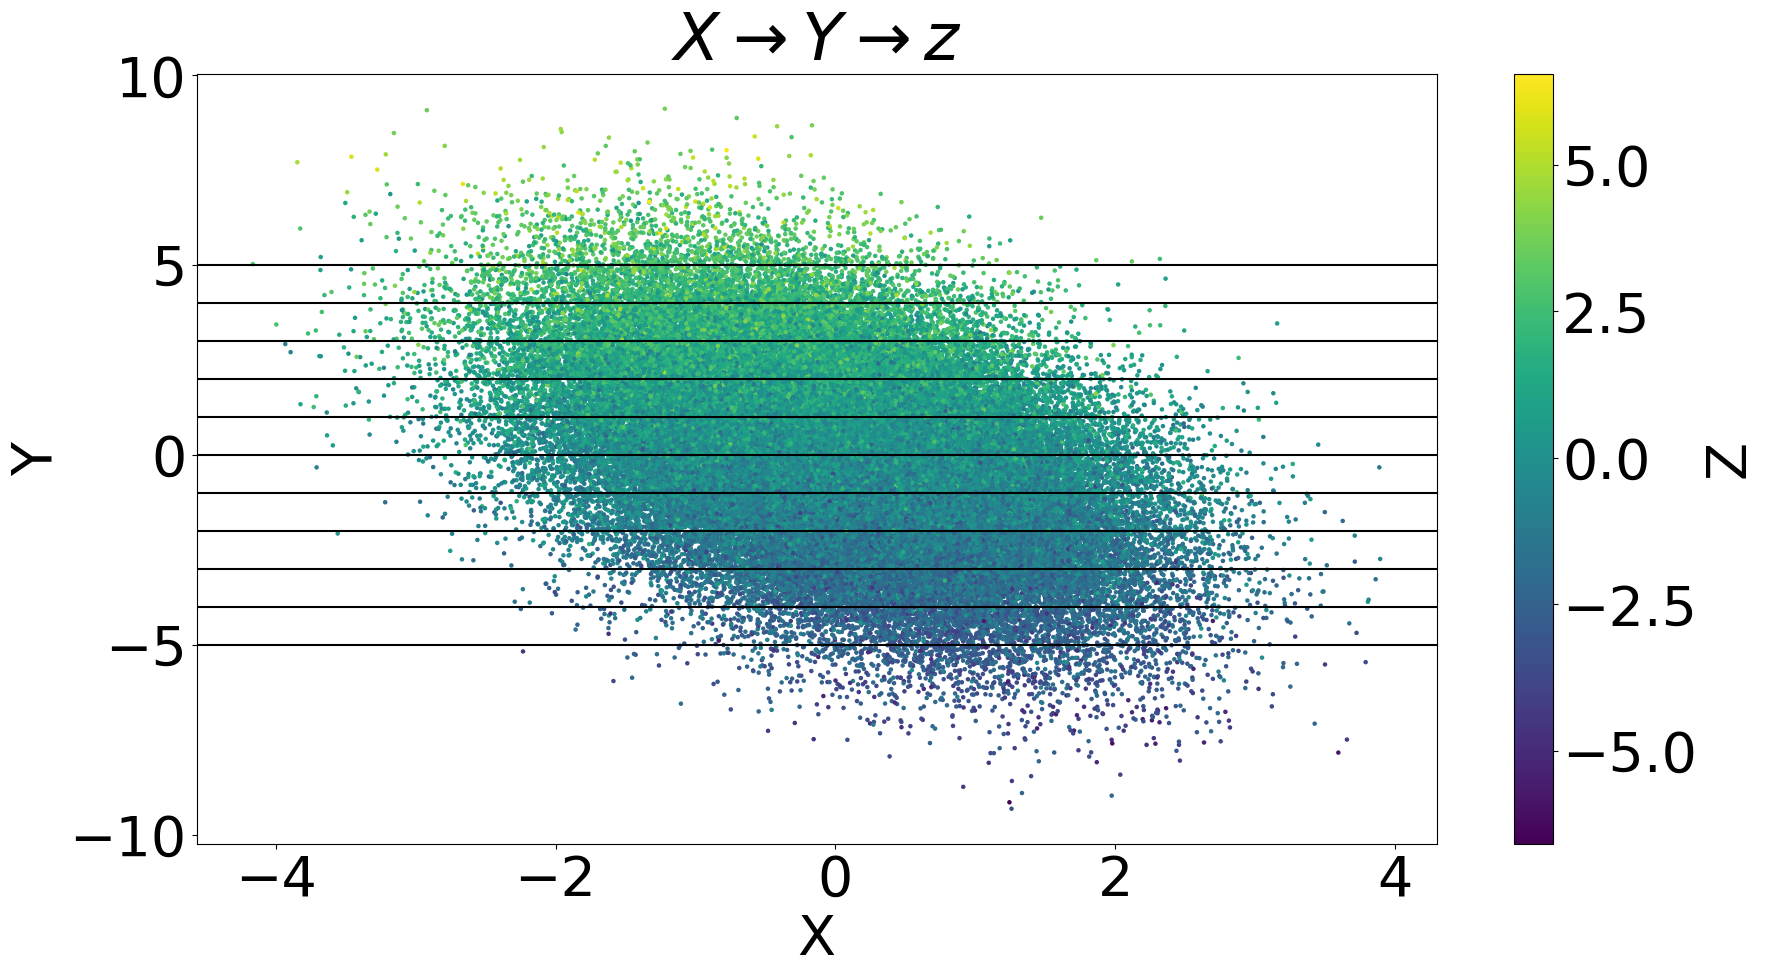

In [12]:
fig, ax = plt.subplots(figsize = (20,10))
chain.plot.scatter(x = "X", y = "Y", c = "Z", cmap = "viridis", s = 5, ax = ax)
ax.set_title("$X \\rightarrow Y \\rightarrow z$")
for i in range(-5,6): ax.axhline(i, c = "k")

## Forks
Suppose that a variable $X$ generates variables $Y$ and $Z$, thus yielding $Y\leftarrow X \rightarrow Z$. And suppose that $Y$ and $Z$ do not directly related. Again, all three variables will be correlated. However, in the case of this fork, correlation between $Y$ and $Z$ is due to confounding from the common cause of $X$. $Y$ and $Z$ are D-separated by $X$.

In [13]:
G = nx.DiGraph()
G.add_edges_from([("X","Y"),("X","Z")])
pos = nx.spring_layout(G)

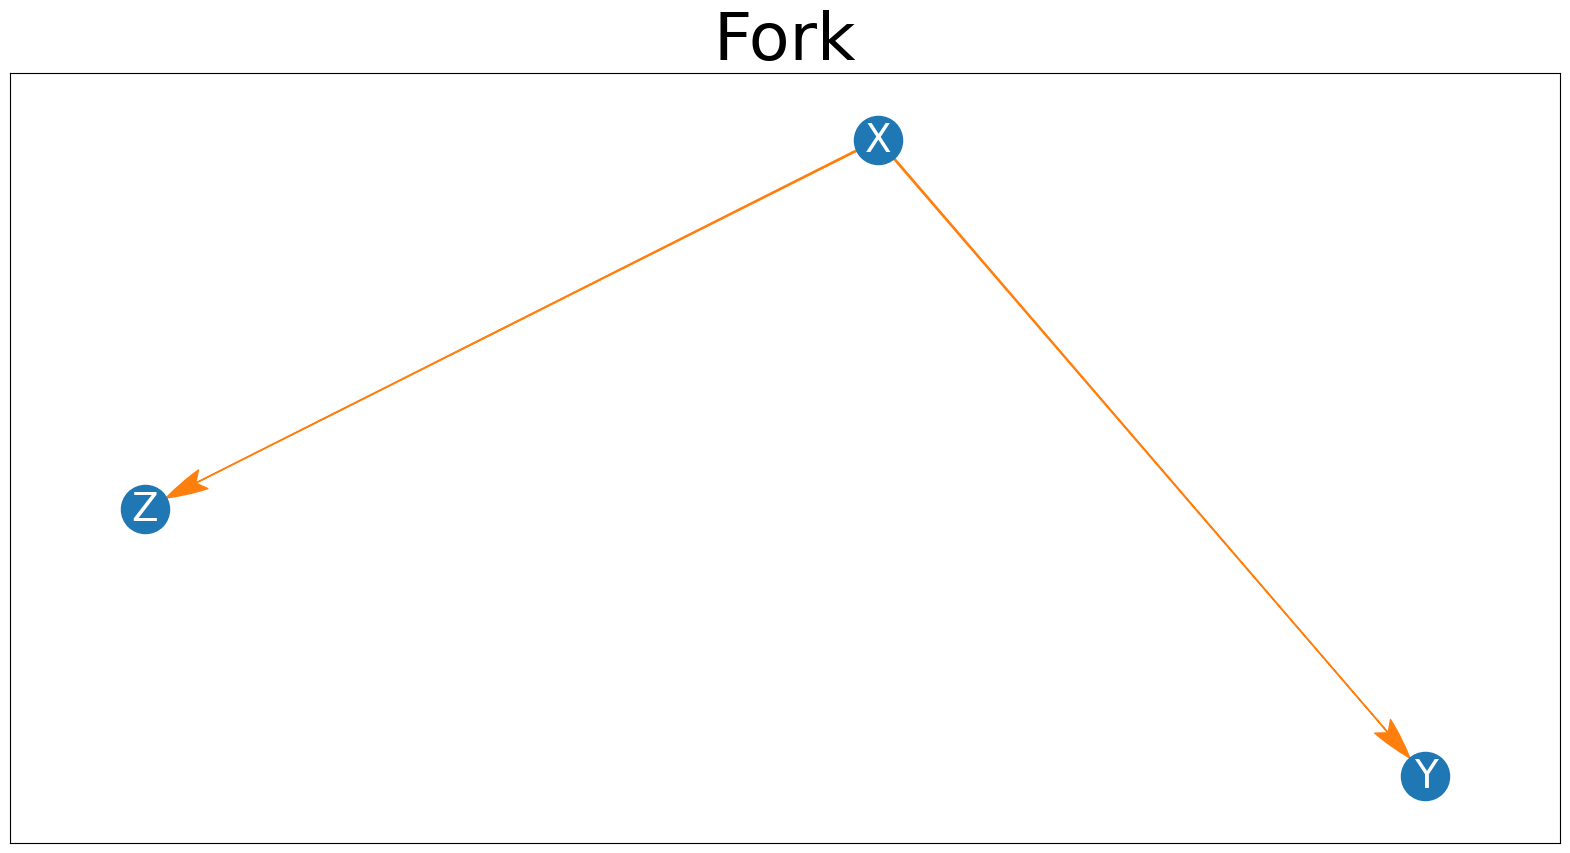

In [14]:
def plot_network(G, pos, title ="", node_size = 1200, 
                 font_color = "white",
                 font_size = 28,
                 alpha = 1, 
                 width = 1, 
                 edge_color = "C1"):
    fig, ax = plt.subplots(figsize = (20,10))
    nx.draw_networkx(G, pos, node_size = node_size,
                     with_labels = True, arrows = True,
                     font_color = font_color,
                     font_size = font_size, alpha = alpha,
                     width = width, edge_color = edge_color,
                     arrowstyle = ArrowStyle(
                         "Fancy, head_length=3, head_width=1.5, tail_width=.1"),
                     ax = ax)
    ax.set_title(title)
plot_network(G, pos, "Fork")

### Creating a Fork

In [15]:
fork = {col:[] for col in cols}
for i in range(length):
    fork["X"].append(np.random.normal(0, 1))
    fork["Y"].append(fork["X"][-1] + np.random.normal(0, 1))
    fork["Z"].append(fork["X"][-1] * 2 + np.random.normal(0, 1))
fork = pd.DataFrame(fork)
fork

X         Y         Z
0      1.323321  0.285319  2.972619
1      0.240677  1.640654  0.177517
2     -0.881401  0.139676 -1.220160
3     -1.376078 -1.862210 -1.617083
4      0.212238  0.849703  0.903025
...         ...       ...       ...
99995  0.443746  1.243582  0.112976
99996 -1.503255 -2.511197 -3.688461
99997  0.676096  2.659374  0.097968
99998  0.742526  1.561829  0.744524
99999  1.903980  2.800481  2.877975

[100000 rows x 3 columns]

In [16]:
fork.corr()

X         Y         Z
X  1.000000  0.710933  0.894855
Y  0.710933  1.000000  0.635632
Z  0.894855  0.635632  1.000000

While all three variables are correlated, we will see that a regression of $Y$ on $X$ and $Z$ will yields a statistically insignificant estimate for $\beta_Z$.

In [17]:
XZc = fork[["X","Z"]]
XZc["Constant"] = 1
Y = fork[["Y"]]
# pass y_var as list for consistent structure
model = sm.OLS(Y, XZc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.505
Model:                            OLS   Adj. R-squared:                  0.505
Method:                 Least Squares   F-statistic:                 5.110e+04
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:59:33   Log-Likelihood:            -1.4140e+05
No. Observations:              100000   AIC:                         2.828e+05
Df Residuals:                   99997   BIC:                         2.828e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.0077      0.007    143.185      0.000       0.994       1.021
Z             -0.0017      0.003     -0.555      0.579      -0.008       0.004
Constant      -0.0037      0.003     -1.165      0.244      -0.010       0.003
==============================================================================
Omnibus:                        0.470   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.791   Jarque-Bera (JB):                0.458
Skew:                           0.001   Prob(JB):                        0.795
Kurtosis:                       3.010   Cond. No.                         5.84
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [18]:
fork.pcorr()

X         Y         Z
X  1.000000  0.412483  0.815904
Y  0.412483  1.000000 -0.001754
Z  0.815904 -0.001754  1.000000

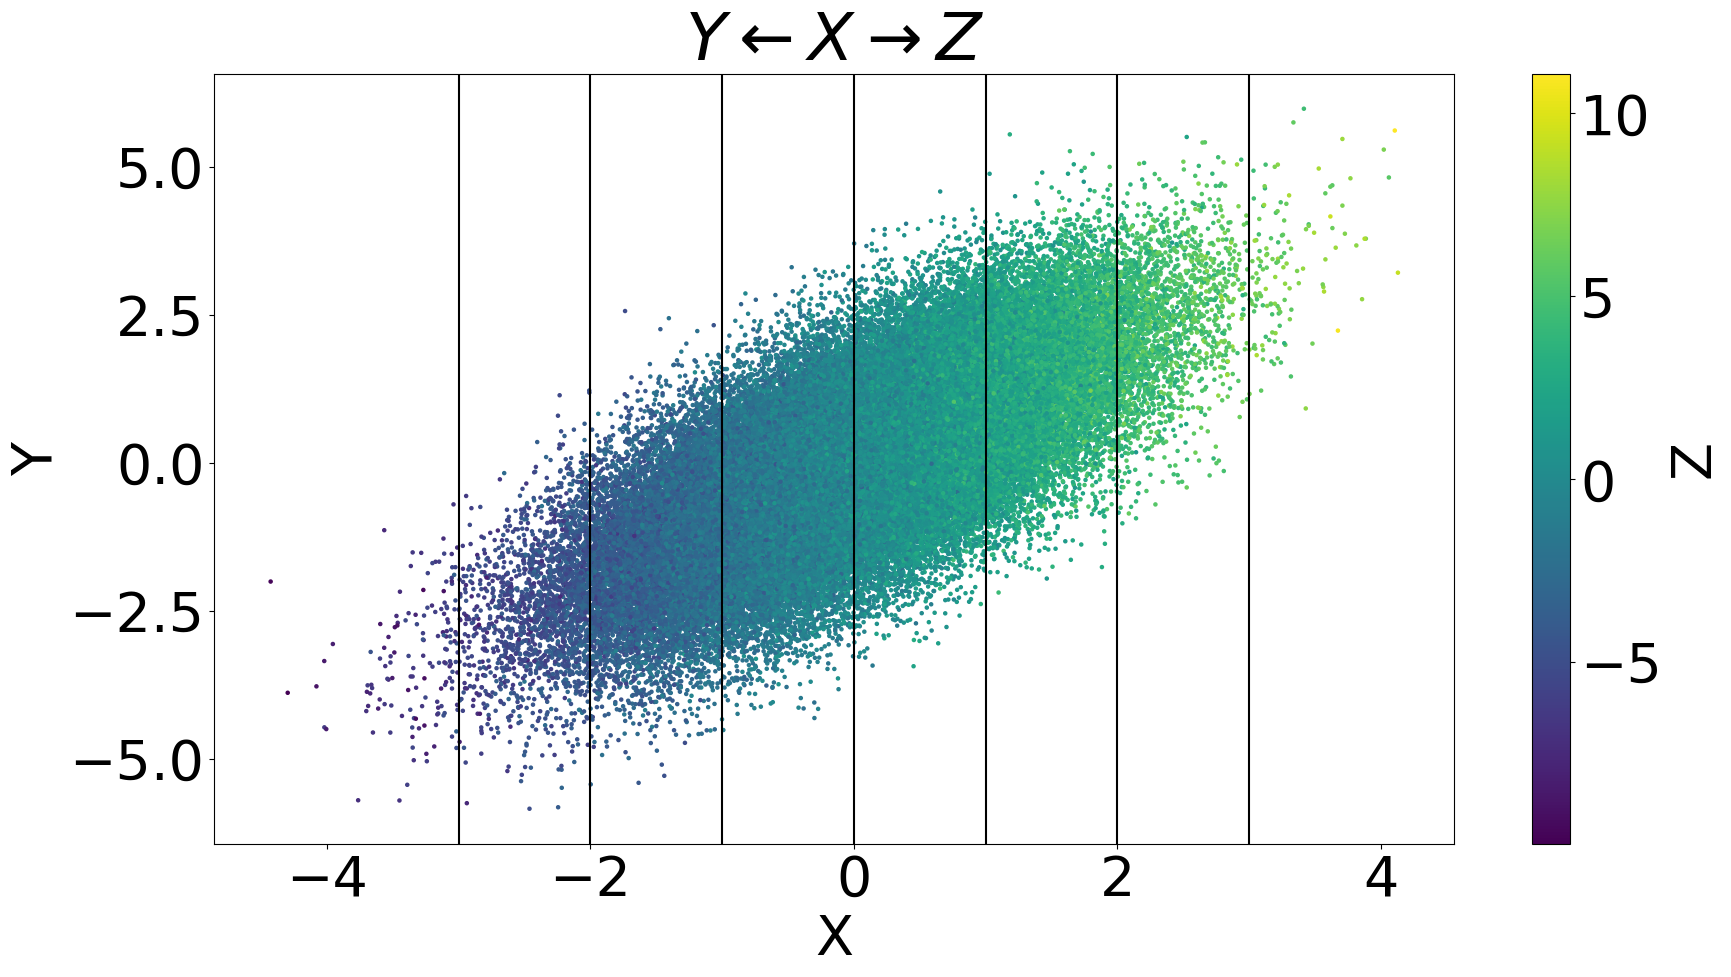

In [19]:
fig, ax = plt.subplots(figsize = (20,10))
fork.plot.scatter(x = "X", y = "Y", c = "Z",
                  s = 5, cmap = "viridis", ax = ax)
ax.set_title("$Y \\leftarrow X \\rightarrow Z$")
for i in range(-3,4): ax.axvline(i, c="k")

## Colliders

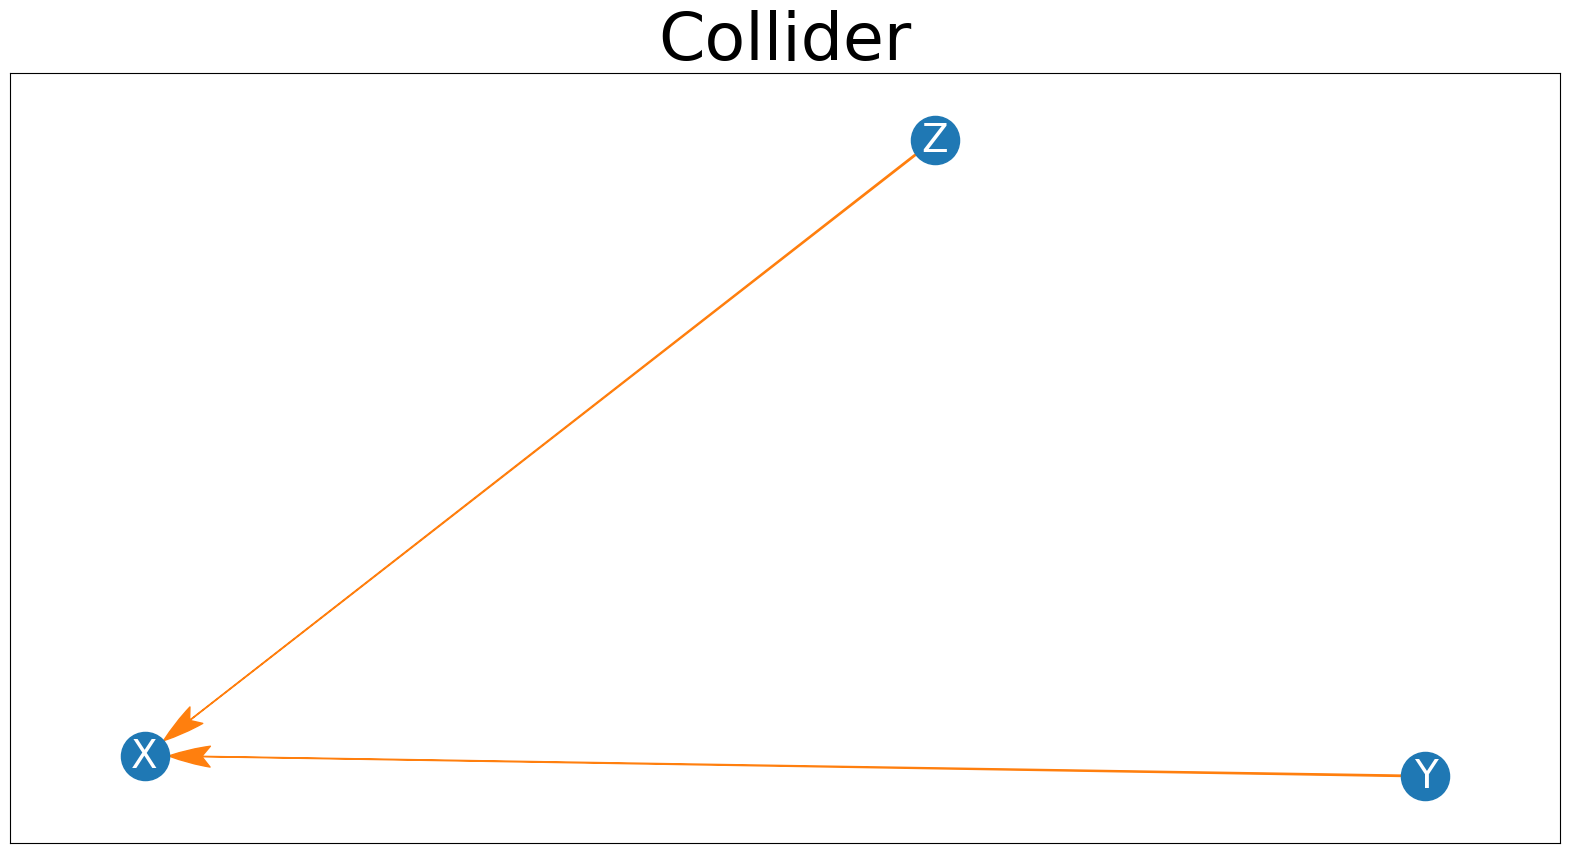

In [20]:
G = nx.DiGraph()
G.add_edges_from([("Y","X"),("Z","X")])
pos = nx.spring_layout(G)
plot_network(G, pos, "Collider")

In [21]:
collider = {col:[] for col in cols}
for i in range(length):
    collider["Y"].append(np.random.normal(0,1))
    collider["Z"].append(np.random.normal(0,1))
    collider["X"].append(collider["Y"][-1] * -.5 + collider["Z"][-1] * .5 + np.random.normal(0,1))
collider = pd.DataFrame(collider)
collider

X         Y         Z
0      0.765003 -0.639828  0.440930
1     -0.583239 -0.794655 -1.497126
2     -0.487037 -0.972133 -0.014918
3      0.251527  0.438837 -0.663916
4     -0.599839 -1.692750 -0.817645
...         ...       ...       ...
99995 -0.999486  1.283126 -0.281680
99996  0.911535 -0.405703  2.080515
99997 -1.570433  0.925627  0.868162
99998 -0.085564 -0.041615 -0.582824
99999 -0.537463  1.684735  0.225466

[100000 rows x 3 columns]

In [22]:
collider.corr()

X         Y         Z
X  1.000000 -0.405172  0.406473
Y -0.405172  1.000000  0.002267
Z  0.406473  0.002267  1.000000

In [23]:
YZc = collider[["Y", "Z"]]
YZc["Constant"] = 1
X = collider[["X"]]
model = sm.OLS(X, YZc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      X   R-squared:                       0.330
Model:                            OLS   Adj. R-squared:                  0.330
Method:                 Least Squares   F-statistic:                 2.464e+04
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:59:36   Log-Likelihood:            -1.4174e+05
No. Observations:              100000   AIC:                         2.835e+05
Df Residuals:                   99997   BIC:                         2.835e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Y             -0.4939      0.003   -156.901      0.000      -0.500      -0.488
Z              0.5001      0.003    157.403      0.000       0.494       0.506
Constant       0.0026      0.003      0.829      0.407      -0.004       0.009
==============================================================================
Omnibus:                        0.881   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.644   Jarque-Bera (JB):                0.879
Skew:                           0.007   Prob(JB):                        0.644
Kurtosis:                       3.001   Cond. No.                         1.01
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
collider.pcorr()

X         Y         Z
X  1.000000 -0.444469  0.445608
Y -0.444469  1.000000  0.199876
Z  0.445608  0.199876  1.000000

Text(0.5, 1.0, '$Y \\rightarrow X \\leftarrow Z$')

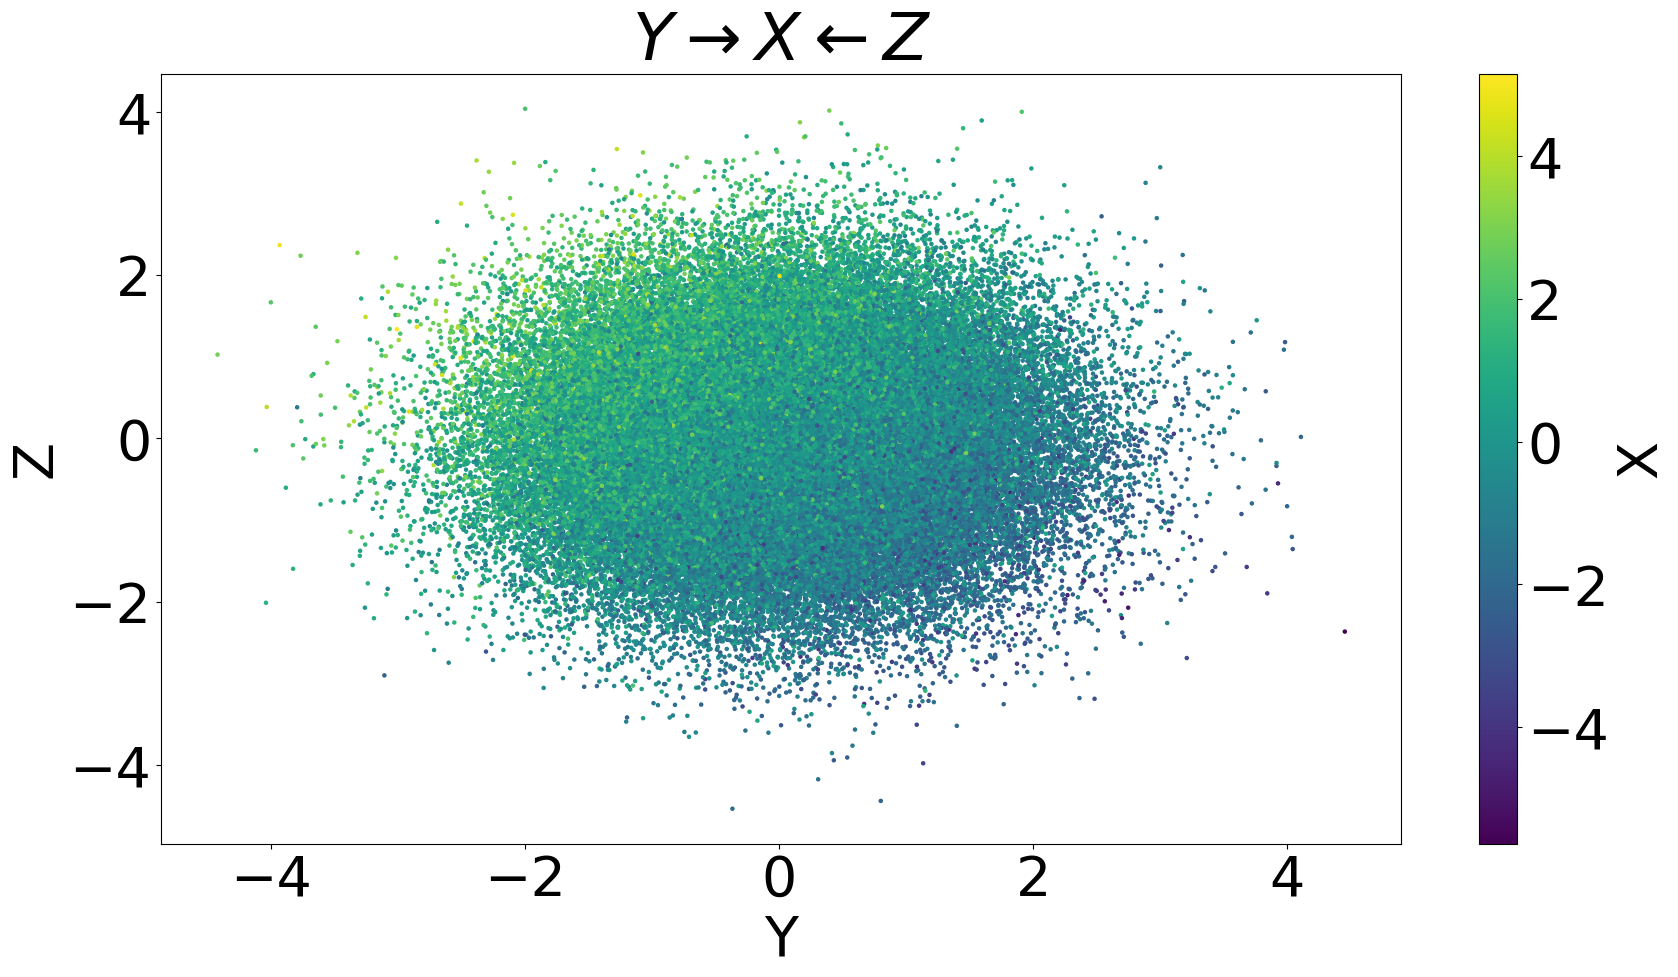

In [25]:
fig,ax = plt.subplots(figsize = (20,10))
collider.plot.scatter(x = "Y", y = "Z", c = "X",s = 5, cmap = "viridis", ax = ax)
ax.set_title("$Y \\rightarrow X \\leftarrow Z$")

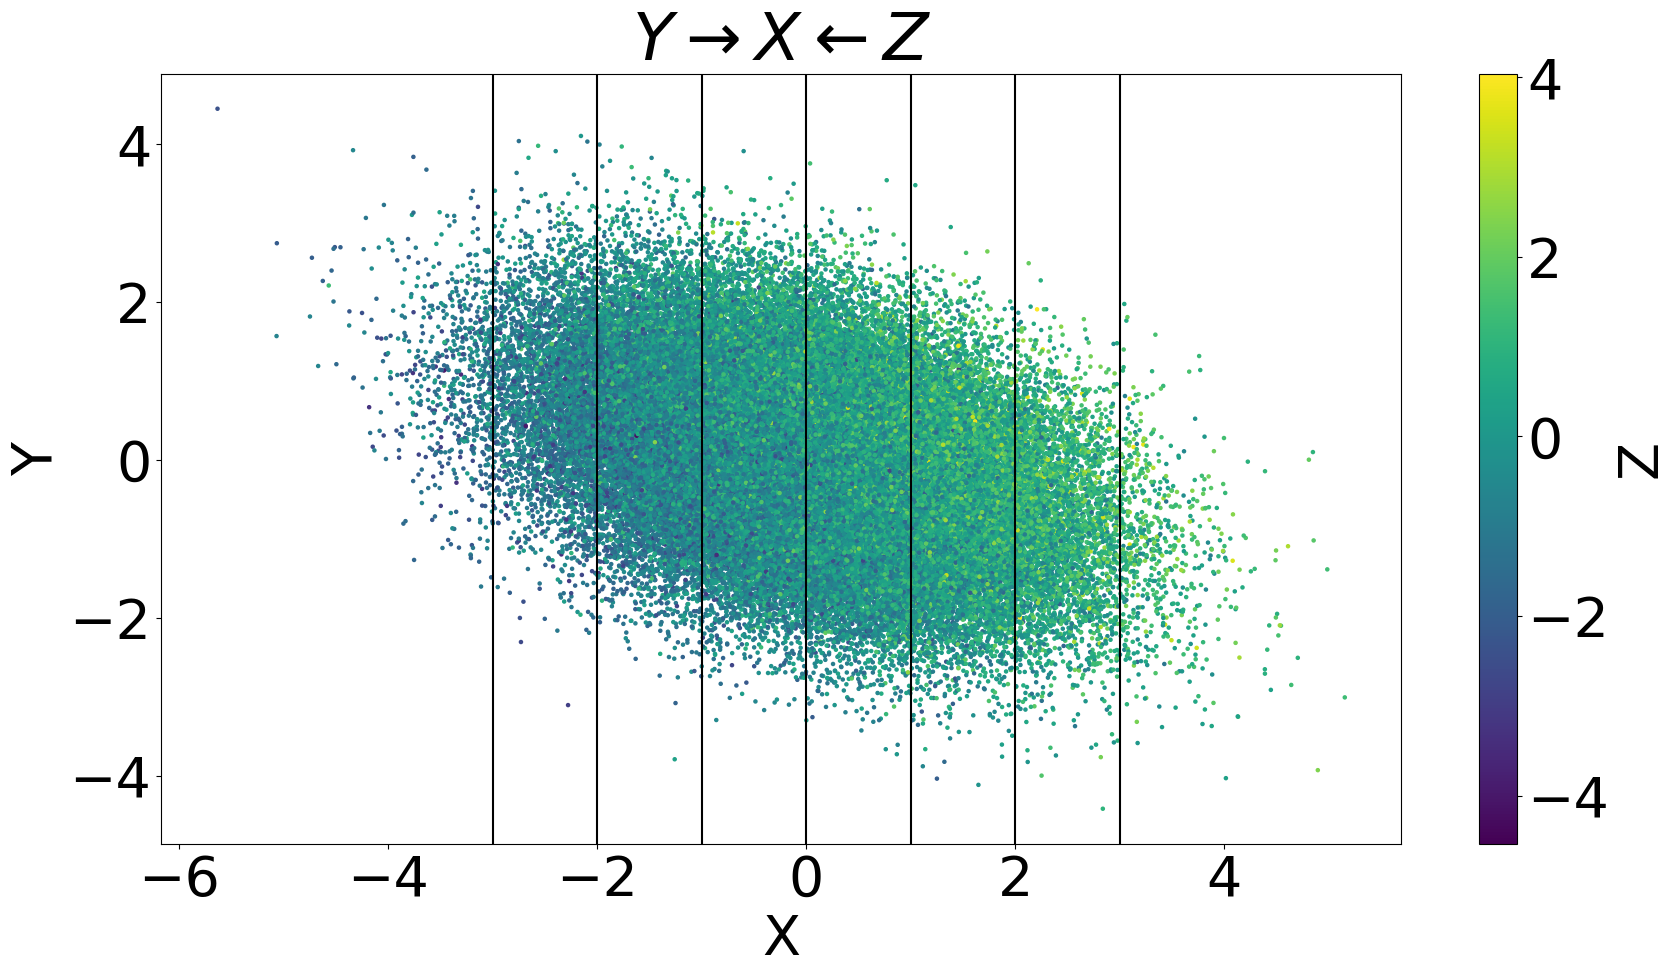

In [26]:
fig,ax = plt.subplots(figsize = (20,10))
collider.plot.scatter(x = "X", y = "Y", c = "Z",s = 5, cmap = "viridis", ax = ax)
ax.set_title("$Y \\rightarrow X \\leftarrow Z$")
for i in range(-3,4): ax.axvline(i, c = "k")

## Problems with Confounding
backdoor

In [27]:
G = nx.DiGraph()
G.add_edges_from([("Q", "X"), ("Q", "Y"), ("X", "Z"), ("Y","Z")])
pos = nx.spring_layout(G)

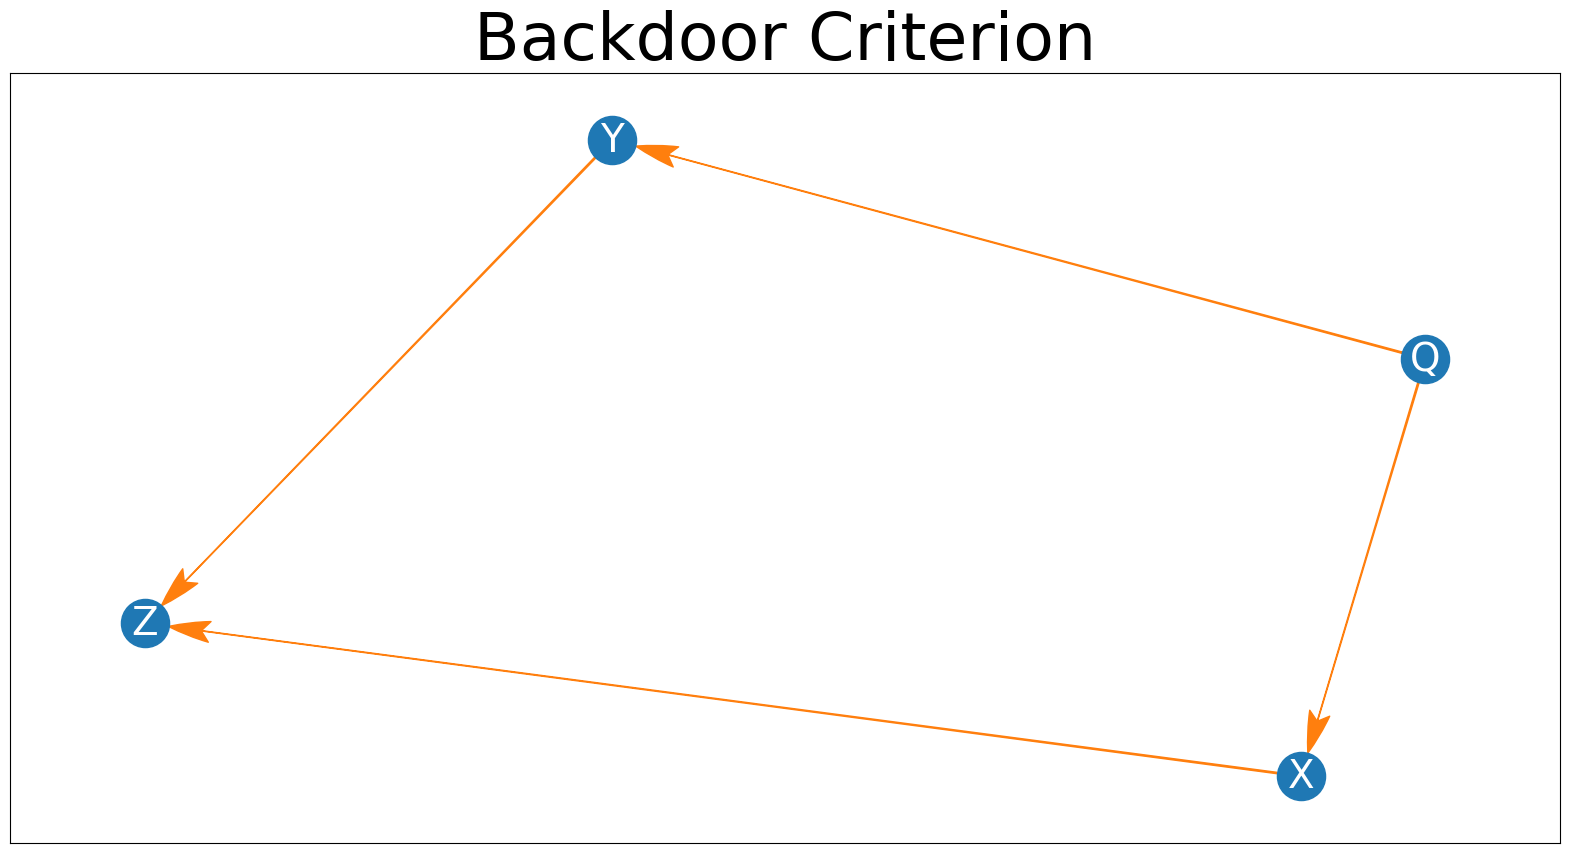

In [28]:
plot_network(G, pos, "Backdoor Criterion")

In [29]:
cols = ["Q", "X", "Y", "Z"]
mu = 0
sigma = 1

backdoor = {col:[] for col in cols}
for i in range(length):
    backdoor["Q"].append(np.random.normal(mu, sigma))
    backdoor["X"].append(3 * backdoor["Q"][-1]  + np.random.normal(mu, sigma ))
    backdoor["Y"].append(backdoor["Q"][-1] * -1 +  np.random.normal(mu, sigma))
    backdoor["Z"].append(1.5 * backdoor["X"][-1] -  backdoor["Y"][-1] * 2 +  np.random.normal(mu,  sigma))

backdoor = pd.DataFrame(backdoor)
backdoor

Q         X         Y         Z
0      1.725286  4.089171 -1.298411  8.946139
1      0.237594 -0.732714 -1.883062  4.507594
2      0.126123 -1.923699 -0.458467 -1.104352
3      0.730356  2.337383 -2.071596  7.338890
4      1.484646  5.747544 -0.596387  9.219980
...         ...       ...       ...       ...
99995  1.044610  3.654929 -1.708737  8.373980
99996 -0.195312  0.122194 -0.876370  3.011681
99997  0.588525 -1.071669 -1.833630  2.248650
99998 -0.149219  0.530786 -0.666029  2.968321
99999 -0.281688  0.939271 -0.261059  1.047882

[100000 rows x 4 columns]

In [30]:
import statsmodels.api as sm

QXYc = backdoor[["Q", "X", "Y"]]
QXYc["Constant"] = 1
Z = backdoor[["Z"]]
# pass y_var as list for consistent structure
model = sm.OLS(Z, QXYc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 1.625e+06
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:59:43   Log-Likelihood:            -1.4145e+05
No. Observations:              100000   AIC:                         2.829e+05
Df Residuals:                   99996   BIC:                         2.829e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Q              0.0085      0.010      0.808      0.419      -0.012       0.029
X              1.4972      0.003    475.355      0.000       1.491       1.503
Y             -1.9981      0.003   -633.723      0.000      -2.004      -1.992
Constant      -0.0027      0.003     -0.868      0.385      -0.009       0.003
==============================================================================
Omnibus:                        5.462   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.065   Jarque-Bera (JB):                5.465
Skew:                          -0.015   Prob(JB):                       0.0651
Kurtosis:                       3.020   Cond. No.                         11.9
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
XYc = backdoor[["X", "Y"]]
model = sm.OLS(Z, XYc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      Z   R-squared (uncentered):                   0.980
Model:                            OLS   Adj. R-squared (uncentered):              0.980
Method:                 Least Squares   F-statistic:                          2.437e+06
Date:                Sun, 21 Apr 2024   Prob (F-statistic):                        0.00
Time:                        15:59:43   Log-Likelihood:                     -1.4145e+05
No. Observations:              100000   AIC:                                  2.829e+05
Df Residuals:                   99998   BIC:                                  2.829e+05
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.4995      0.001   1118.921      0.000       1.497       1.502
Y             -1.9989      0.003   -664.212      0.000      -2.005      -1.993
==============================================================================
Omnibus:                        5.496   Durbin-Watson:                   1.997
Prob(Omnibus):                  0.064   Jarque-Bera (JB):                5.499
Skew:                          -0.015   Prob(JB):                       0.0639
Kurtosis:                       3.020   Cond. No.                         3.32
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Frontdoor Criterion

In [32]:
cols = ["Q", "X", "Y", "Z"]
mu = 0
sigma = 1

frontdoor = {col:[] for col in cols}
for i in range(length):
    frontdoor["Q"].append(np.random.normal(mu, sigma))
    frontdoor["X"].append(10 * frontdoor["Q"][-1] + np.random.normal(mu, sigma))
    frontdoor["Y"].append(frontdoor["X"][-1] * 2 + np.random.normal(mu, sigma))
    frontdoor["Z"].append(frontdoor["Q"][-1] * -1 + frontdoor["Y"][-1] + np.random.normal(mu, sigma))
frontdoor = pd.DataFrame(frontdoor)
frontdoor

Q          X          Y          Z
0      2.400021  23.435910  47.590508  44.543624
1     -0.677431  -4.261042  -7.037200  -7.178454
2     -0.768380  -6.255215 -14.501029 -13.441210
3     -0.823357  -7.155721 -15.415411 -15.422769
4      0.524901   5.868274  12.373498  10.815870
...         ...        ...        ...        ...
99995  0.589047   4.874557   9.421417   8.814515
99996  0.061729  -1.032212  -3.321412  -4.365445
99997 -1.474369 -15.737910 -32.261522 -31.434644
99998 -0.795857  -5.905869 -12.736529 -11.114512
99999 -1.777657 -18.460084 -35.846174 -36.338437

[100000 rows x 4 columns]

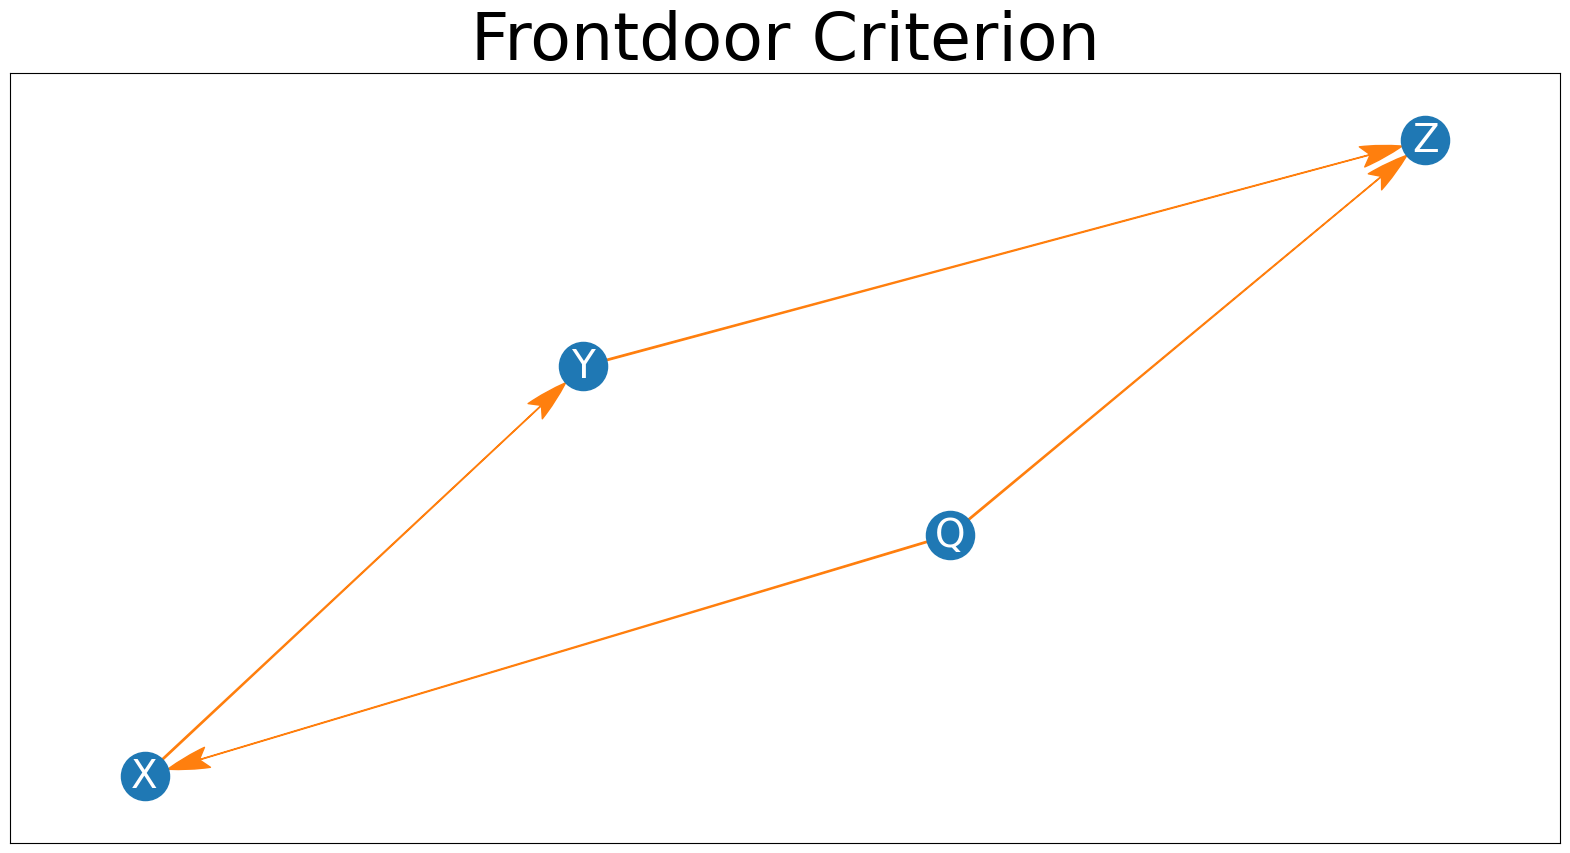

In [33]:
G = nx.DiGraph()
G.add_edges_from([("Q","X"),("Q","Z"), ("X","Y"),("Y","Z")])
pos = nx.spring_layout(G)
plot_network(G, pos, "Frontdoor Criterion")

In [34]:
Xc = frontdoor[["X"]]
Xc["Constant"] = 1
Z = frontdoor[["Z"]]
model = sm.OLS(Z, Xc)
results = model.fit()
results.summary()

C:\Users\aleah\AppData\Local\Temp\ipykernel_22712\1536465617.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Xc["Constant"] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 1.831e+07
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:59:44   Log-Likelihood:            -1.7642e+05
No. Observations:              100000   AIC:                         3.528e+05
Df Residuals:                   99998   BIC:                         3.529e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X              1.9013      0.000   4279.500      0.000       1.900       1.902
Constant      -0.0027      0.004     -0.612      0.540      -0.011       0.006
==============================================================================
Omnibus:                        1.573   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.455   Jarque-Bera (JB):                1.563
Skew:                          -0.007   Prob(JB):                        0.458
Kurtosis:                       3.014   Cond. No.                         10.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [35]:
XYc = frontdoor[["X", "Y"]]
XYc["Constant"] = 1
Z = frontdoor[["Z"]]
model = sm.OLS(Z, XYc)
results = model.fit()
results.summary()

C:\Users\aleah\AppData\Local\Temp\ipykernel_22712\3814303157.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  XYc["Constant"] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.817e+07
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:59:44   Log-Likelihood:            -1.4228e+05
No. Observations:              100000   AIC:                         2.846e+05
Df Residuals:                   99997   BIC:                         2.846e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
X             -0.0847      0.006    -13.329      0.000      -0.097      -0.072
Y              0.9929      0.003    312.955      0.000       0.987       0.999
Constant      -0.0057      0.003     -1.800      0.072      -0.012       0.001
==============================================================================
Omnibus:                        0.371   Durbin-Watson:                   2.010
Prob(Omnibus):                  0.831   Jarque-Bera (JB):                0.363
Skew:                          -0.004   Prob(JB):                        0.834
Kurtosis:                       3.005   Cond. No.                         50.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
QXc = frontdoor[["Q", "X"]]
QXc["Constant"] = 1
Z = frontdoor[["Z"]]
model = sm.OLS(Z, QXc)
results = model.fit()
results.summary()

C:\Users\aleah\AppData\Local\Temp\ipykernel_22712\2209165990.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  QXc["Constant"] = 1


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.995
Model:                            OLS   Adj. R-squared:                  0.995
Method:                 Least Squares   F-statistic:                 9.195e+06
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:59:44   Log-Likelihood:            -1.7622e+05
No. Observations:              100000   AIC:                         3.524e+05
Df Residuals:                   99997   BIC:                         3.525e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Q             -0.9077      0.045    -20.271      0.000      -0.995      -0.820
X              1.9912      0.004    446.899      0.000       1.982       2.000
Constant      -0.0027      0.004     -0.603      0.546      -0.011       0.006
==============================================================================
Omnibus:                        1.624   Durbin-Watson:                   2.003
Prob(Omnibus):                  0.444   Jarque-Bera (JB):                1.614
Skew:                          -0.007   Prob(JB):                        0.446
Kurtosis:                       3.014   Cond. No.                         102.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
QXYc = frontdoor[["Q","X","Y"]]
QXYc["Constant"] = 1
Z = frontdoor[["Z"]]
model = sm.OLS(Z, QXYc)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Z   R-squared:                       0.997
Model:                            OLS   Adj. R-squared:                  0.997
Method:                 Least Squares   F-statistic:                 1.223e+07
Date:                Sun, 21 Apr 2024   Prob (F-statistic):               0.00
Time:                        15:59:44   Log-Likelihood:            -1.4181e+05
No. Observations:              100000   AIC:                         2.836e+05
Df Residuals:                   99996   BIC:                         2.837e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Q             -0.9744      0.032    -30.696      0.000      -1.037      -0.912
X              0.0105      0.007      1.489      0.137      -0.003       0.024
Y              0.9935      0.003    314.623      0.000       0.987       1.000
Constant      -0.0057      0.003     -1.793      0.073      -0.012       0.001
==============================================================================
Omnibus:                        0.274   Durbin-Watson:                   2.009
Prob(Omnibus):                  0.872   Jarque-Bera (JB):                0.274
Skew:                          -0.004   Prob(JB):                        0.872
Kurtosis:                       3.000   Cond. No.                         227.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Generate Artificial Data to be used to Detect a Directed Acyclic Graph

In [38]:
cols = ["P", "Q", "X", "Y", "Z"]
mu = 0
sigma = 5

lst_dct = {col: [] for col in cols}
for i in range(length):
    lst_dct["P"].append(np.random.normal(mu, 0.5 * sigma))
    lst_dct["Q"].append(np.random.normal(mu, sigma))
    lst_dct["X"].append(3 * lst_dct["Q"][-1] + np.random.normal(mu, sigma))
    lst_dct["Y"].append(lst_dct["Q"][-1] + np.random.normal(mu, sigma))
    lst_dct["Z"].append(lst_dct["P"][-1] * 2 + lst_dct["X"][-1] + lst_dct["Y"][-1] * -2 + np.random.normal(mu, sigma))
df = pd.DataFrame(lst_dct)
df

P         Q          X          Y          Z
0      1.472461  2.254546  10.386539  -0.123708  19.790711
1      0.868453 -0.961714 -12.476710  -4.733409  -6.751796
2      0.124644 -4.854130  -9.204353  -3.514111   4.663978
3     -3.128097 -0.383336  -0.510627   3.152337 -12.677677
4      1.306346  7.605728  22.928874  17.712514  -5.885102
...         ...       ...        ...        ...        ...
99995 -1.968754  0.521968   7.882776   5.091407  -5.149618
99996 -0.435268  8.643425  30.604557   1.622469  28.197849
99997  1.138358  8.906664  21.878729  15.636043 -10.579000
99998 -1.791648 -3.735432  -8.653558  -4.987223  -6.930623
99999 -2.934477  2.010123  14.199494   4.167739   4.792898

[100000 rows x 5 columns]

### Using Partial Correlations to Build a Causal Skeleton
1. Build a fully connected graph
2. For each variable, test every possible with the remaining variables. If a correlation between, for example, variables $X$ and $Y$ is not statistically significant, remove the link $XY$.
3. For variables whose correlation is statistically significant, test every possible combination of control variables. If the statistical significance of any of the tested partial correlations is broken, remove the link $XY$.
4. If after steps 2 and 3, the link $XY$ remains that link will be included in the skeleton.  

#### Build Undirected Graph

In [39]:
cols = ["P", "Q", "X", "Y", "Z"]
undirected_graph = {key:[a for a in cols if a != key] for key in cols}
undirected_graph

{'P': ['Q', 'X', 'Y', 'Z'],
 'Q': ['P', 'X', 'Y', 'Z'],
 'X': ['P', 'Q', 'Y', 'Z'],
 'Y': ['P', 'Q', 'X', 'Z'],
 'Z': ['P', 'Q', 'X', 'Y']}

In [40]:
graph_list = []
for source, sinks in undirected_graph.items():
    for sink in sinks:
        graph_list.append((source, sink))
graph_list

[('P', 'Q'),
 ('P', 'X'),
 ('P', 'Y'),
 ('P', 'Z'),
 ('Q', 'P'),
 ('Q', 'X'),
 ('Q', 'Y'),
 ('Q', 'Z'),
 ('X', 'P'),
 ('X', 'Q'),
 ('X', 'Y'),
 ('X', 'Z'),
 ('Y', 'P'),
 ('Y', 'Q'),
 ('Y', 'X'),
 ('Y', 'Z'),
 ('Z', 'P'),
 ('Z', 'Q'),
 ('Z', 'X'),
 ('Z', 'Y')]

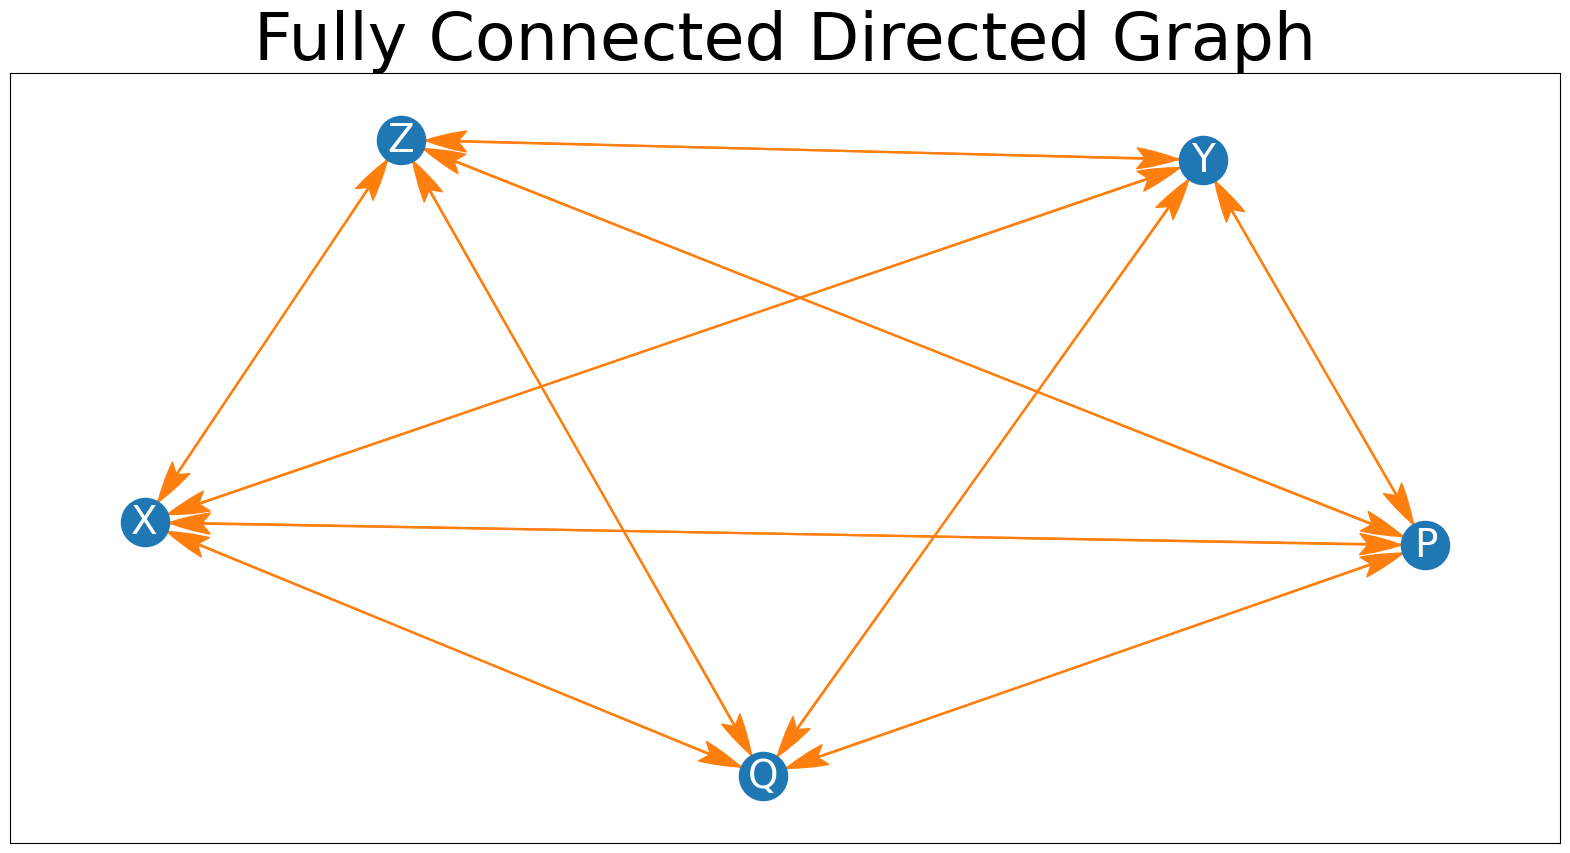

In [41]:
G = nx.DiGraph()
G.add_edges_from(graph_list)
pos= nx.spring_layout(G)
plot_network(G, pos, "Fully Connected Directed Graph")

### Infer Graphical Skeleton from Data

In [ ]:
import copy
p_val = 0.01

def build_skeleton(df, undirected_graph):
    def check_remaining_controls(control, undirected_graph, x, y, controls_used):
        for c_var in control_vars:
            c_used = copy.copy(controls_used)
            if y in undirected_graph[x]:
                c_used.append(c_var)
                test = df.partial_corr(x =x, y = y, covar = c_used,
                                      method = "pearson")
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
                    break
                else:
                    remaining_controls = copy.copy(control_vars).remove(c_var)
                    check_remaining_controls(remaining_controls, undirected_graph, x, y, c_used)
        
        
        
    for x in df.keys():
        ys = undirected_graph[x]
        for y in df.keys():
            if x != y:
                #first check for correlation with no controls
                test = df.partial_corr(x = x,
                                       y = y, 
                                       covar = None,
                                       method = "pearson")
                if test["p-val"].values[0] > p_val:
                    undirected_graph[x].remove(y)
                    
                else:
                    control_vars = [z for z in df.keys() if z != y and z != x]
                    check_remaining_controls(control_vars, undirected_graph, x, y, [])
                    
    return undirect_graph                
build_skeleton(df, undirected_graph)

C:\Users\aleah\anaconda3\Lib\site-packages\pingouin\correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
C:\Users\aleah\anaconda3\Lib\site-packages\pingouin\correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
C:\Users\aleah\anaconda3\Lib\site-packages\pingouin\correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
C:\Users\aleah\anaconda3\Lib\site-packages\pingouin\correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
C:\Users\aleah\anaconda3\Lib\site-packages\pingouin\correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
C:\Users\aleah\anaconda3\Lib\site-packages\pingouin\correlation.py:866: RuntimeWarning: invalid value encountered in sqrt
  D = np.diag(np.sqrt(1 / Vi_diag))
C:\Users\aleah\anaconda3\Lib\site-packages\pingouin\

In [ ]:
graph_list = []
for source, sinks in undirected_graph.items():
    for sink in sinks:
        graph_list.append((source, sink))
G = nx.DiGraph()
G.add_edges_from(graph_list)
pos = nx.spring_layout(G)
plot_network(G, pos, "Fully Connected Directed Graph")       

In [ ]:
from pgmy.estimators import PC
c = PC(df)
max_cond_vars = len(df.keys()) - 2

model = c.estimate(return_type = "dog", variant = "parallel", #"parallel", "stable"
                  significance_level = p_val,
                  max_cond_vars = max_cond_vars,
                  ci_test = "pearsonr")
edges = model.edges()

In [ ]:
def graph_DAG(edges, df, title = "")
    graph = nx.DiGraph()
    
################################
    edge_labels = {}
    for edge in edges:
        controls = [key for key in df.keys() if key not in edge]
        controls = list(set(controls))
        keep_controls = []
        for control in controls:
            control_edges = [ctrl_edge for ctrl_edge in edges if control == ctrl_edge[0] ]
            if (control, edge[1]) in control_edges:
                keep_controls.append(control)
            pcorr = df[[edge[0], edge[1]]+ keep_controls].pcorr()
            edge_labels[edge] = str(round(pcorr[edge[0]].loc[edge[1]],2))   
############# END ADD #################   
    graph.add_edges_from(edges)
    color_map = ["C0" for g in graph]
    fig, ax = plt.subplots(figsize = (20,12))
    graph.nodes()
    plt.tight_layout()
    pos = nx.spring_layout(graph)
    plt.title(title, fontsize = 30)
    nx.draw_networks(graph, pos, node_color = color_map, node_size = 1200,
    with_labels = True, arrows = True,
    font_color = "white",
    font_size = 26, alpha = 1,
    width = 2, edge_color = "C1",
    arrowstyle = ArrowStyle("Fancy, head_length=1.5, head_width=1.5, tail_width=0.1"),
    ax = ax)
##################################
    nx.draw_networkx_edge_labels(graph, pos, 
                                edge_labels = edge_labels,
                                font_color = "green"
                                font_size = 20)
graph_DAG(edges, df, title = "Directed Acyclic Graph")